Scientific Visualization 2025/2026 - Sara Mancini (66458A) & Betül Gül (V13000)
<h1> Explaining Clusters: Heart Failure Clinical Records Dataset (UCI) </h3>

### Imports

In [ ]:
!pip -q install shap hdbscan umap-learn

In [ ]:
import umap

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from statsmodels.stats.multitest import multipletests

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,5)

# Opsiyoneller:
try:
    import hdbscan
    HAS_HDBSCAN = True
except Exception:
    HAS_HDBSCAN = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

import warnings
warnings.filterwarnings("ignore")



/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


###Dataset download

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
df_raw = pd.read_csv(url)
print("Dataset shape:", df_raw.shape)
display(df_raw.head())

Dataset shape: (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Data scaling and preprocessing

In [3]:
df = df_raw.copy()

continuous_cols = [
    'age',
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium',
    'time'
]

binary_cols = [
    'anaemia',
    'diabetes',
    'high_blood_pressure',
    'sex',
    'smoking'
]

feature_cols = continuous_cols + binary_cols
target_col = 'DEATH_EVENT'

for c in feature_cols + [target_col]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(df[continuous_cols])

X_proc = np.hstack([X_cont_scaled, df[binary_cols].values])

final_feature_names = continuous_cols + binary_cols

print("Processed matrix shape:", X_proc.shape)
print("Example feature names:", final_feature_names[:8])

Processed matrix shape: (299, 12)
Example feature names: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'anaemia']


### K-Means

In [4]:
def try_kmeans_k(X, k_range=range(2,9), random_state=42):
    rows = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
        labels = km.fit_predict(X)
        try: sil = silhouette_score(X, labels)
        except: sil = np.nan
        try: db = davies_bouldin_score(X, labels)
        except: db = np.nan
        rows.append({'k': k, 'silhouette': sil, 'davies_bouldin': db})
    return pd.DataFrame(rows)

km_scores = try_kmeans_k(X_proc, range(2,9))
best_row = km_scores.sort_values(['silhouette','davies_bouldin'], ascending=[False, True]).iloc[0]
best_k = int(best_row['k'])
print("Selected K:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto').fit(X_proc)
labels_kmeans = kmeans.labels_

dfc = df.copy()
dfc['cluster'] = labels_kmeans

print("KMeans cluster counts:\n", pd.Series(labels_kmeans).value_counts())
dfc.head()

Selected K: 5
KMeans cluster counts:
 1    109
0     97
3     77
2     10
4      6
Name: count, dtype: int64


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,cluster
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,4
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,0
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,0


### 1. Feature summarization by cluster

In [5]:
def summarize_continuous(dff, cont_cols, cl='cluster'):
    out = {}
    for c in cont_cols:
        grp = dff.groupby(cl)[c]
        out[c] = pd.DataFrame({
            'mean': grp.mean(),
            'std': grp.std(),
            'median': grp.median(),
            'n': grp.count()
        })
    return out

def summarize_binary(dff, bin_cols, cl='cluster'):
    out = {}
    for b in bin_cols:
        tab = dff.groupby(cl)[b].agg(['sum','count'])
        tab['prop'] = tab['sum'] / tab['count']  # 1 oranı
        out[b] = tab
    return out

cont_summ = summarize_continuous(dfc, continuous_cols)
bin_summ  = summarize_binary(dfc, binary_cols)

# Örnek inceleme:
cont_summ['age'], bin_summ['diabetes']


(              mean        std  median    n
 cluster                                   
 0        58.247423   9.574305    60.0   97
 1        56.415908   9.824717    55.0  109
 2        66.100000   9.421606    62.5   10
 3        69.727273  12.186745    70.0   77
 4        60.000000  18.460769    53.5    6,
          sum  count      prop
 cluster                      
 0         40     97  0.412371
 1         57    109  0.522936
 2          3     10  0.300000
 3         24     77  0.311688
 4          1      6  0.166667)

#### Box Plots of Distributions

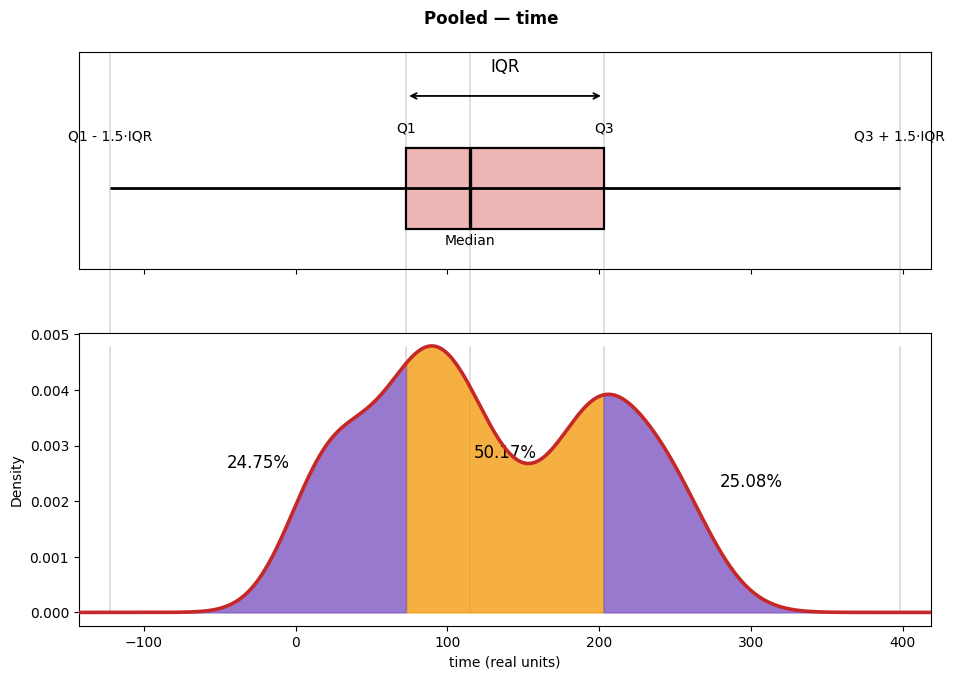

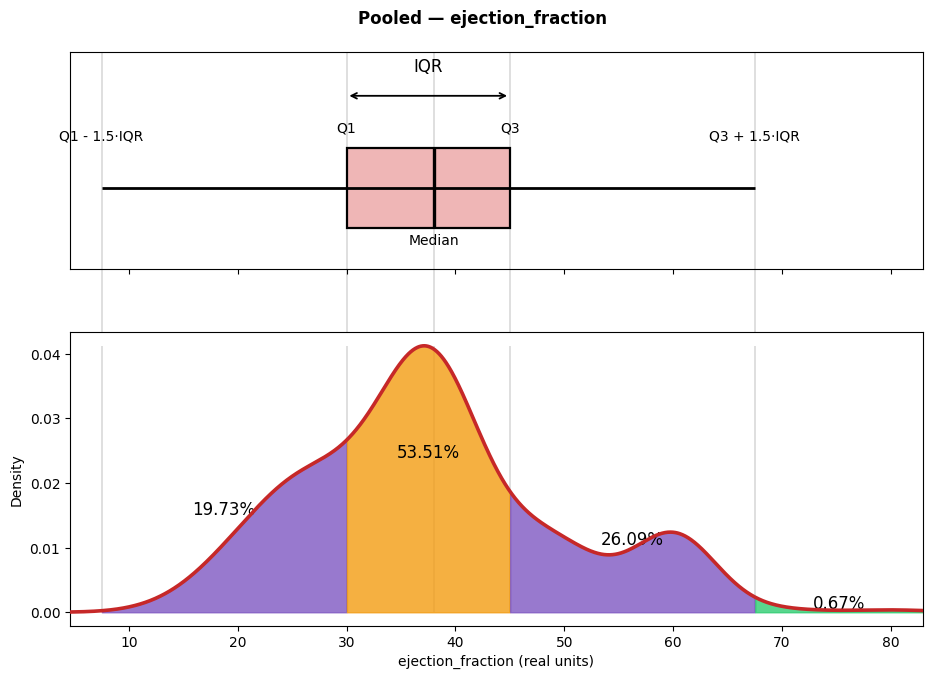

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

# ---------------- Helpers ----------------
def _x_to_figfrac(fig, ax, x):
    xd = ax.transData.transform((x, 0))[0]
    return fig.transFigure.inverted().transform((xd, 0))[0]

def _connect_vertical_lines(fig, ax_top, ax_bot, xs, color='0.80', lw=1.3):
    p_top, p_bot = ax_top.get_position(), ax_bot.get_position()
    y_top_bottom = p_top.y0
    y_bot_top    = p_bot.y1
    for x in xs:
        xf = _x_to_figfrac(fig, ax_top, x)
        fig.add_artist(Line2D([xf, xf], [y_bot_top, y_top_bottom],
                              transform=fig.transFigure, color=color, lw=lw, zorder=0))

def _pct(p):
    return f"{100*p:.2f}%"

# ---------------- Core plot ----------------
def plot_feature_real_distribution(dfx, variable, suptitle=None):
    x = dfx[variable].dropna().astype(float).values
    if x.size < 5:
        print(f"⚠️ {variable}: yeterli gözlem yok.")
        return

    # Gerçek özetler
    Q1, MED, Q3 = np.percentile(x, [25, 50, 75])
    IQR = Q3 - Q1
    LW, UW = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    xmin, xmax = min(x.min(), LW), max(x.max(), UW)
    pad = 0.04*(xmax - xmin) if xmax > xmin else 1.0
    xmin -= pad; xmax += pad

    # KDE (Scott kuralı; ekstra düzleştirme yok)
    kde = gaussian_kde(x, bw_method='scott')
    xs  = np.linspace(xmin, xmax, 1500)
    ys  = kde(xs)
    ys /= np.trapz(ys, xs)  # alan=1

    # Empirik bölge oranları
    p_left  = (x <  LW).mean()
    p_q1    = ((x >= LW) & (x < Q1)).mean()
    p_mid   = ((x >= Q1) & (x < Q3)).mean()
    p_q3    = ((x >= Q3) & (x < UW)).mean()
    p_right = (x >= UW).mean()

    regions = [
        (-np.inf, LW, '#2ecc71', p_left),
        (LW, Q1,   '#7e57c2', p_q1),
        (Q1, Q3,   '#f39c12', p_mid),
        (Q3, UW,   '#7e57c2', p_q3),
        (UW, np.inf,'#2ecc71', p_right),
    ]

    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(11, 7),
        gridspec_kw={"height_ratios":[1, 1.35]},
        sharex=True
    )
    plt.subplots_adjust(hspace=0.25, top=0.92, bottom=0.10)

    # --- Üst panel (box şema) ---
    seams = [LW, Q1, MED, Q3, UW]
    for v in seams:
        ax_top.vlines(v, -0.20, 0.34, color='0.85', lw=1.2, zorder=0)

    ax_top.hlines(0, LW, UW, color='black', lw=2.0)
    ax_top.add_patch(Rectangle((Q1, -0.10), Q3-Q1, 0.20,
                               facecolor='#efb6b6', edgecolor='black', lw=1.6))
    ax_top.vlines(MED, -0.10, 0.10, color='black', lw=2.4)

    ax_top.annotate('', xy=(Q1, 0.23), xytext=(Q3, 0.23),
                    arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'))
    ax_top.text((Q1+Q3)/2, 0.28, "IQR", ha='center', va='bottom', fontsize=12)
    ax_top.text(Q1,  0.14, "Q1", ha='center')
    ax_top.text(Q3,  0.14, "Q3", ha='center')
    ax_top.text(MED, -0.14, "Median", ha='center')
    ax_top.text(LW,  0.12, "Q1 - 1.5·IQR", ha='center')
    ax_top.text(UW,  0.12, "Q3 + 1.5·IQR", ha='center')

    ax_top.set_xlim(xmin, xmax)
    ax_top.set_ylim(-0.20, 0.34)
    ax_top.set_yticks([])
    for s in ax_top.spines.values(): s.set_visible(True)

    # --- Alt panel (KDE + bölgeler) ---
    ax_bot.plot(xs, ys, lw=2.6, color='#c62828', zorder=5)
    y_max = ys.max()

    for (a,b,c,p) in regions:
        xl, xr = max(xmin,a), min(xmax,b)
        mask = (xs >= xl) & (xs <= xr)
        if mask.any() and p > 0:
            ax_bot.fill_between(xs[mask], 0, ys[mask], color=c, alpha=0.80, zorder=2)
            xm = (xl + xr) / 2
            y_reg = ys[mask].max()
            ax_bot.text(xm, 0.60*y_reg, _pct(p), ha='center', va='center', fontsize=12)

    for v in seams:
        ax_bot.vlines(v, 0, y_max, color='0.85', lw=1.2, zorder=1)

    ax_bot.set_xlim(xmin, xmax)
    ax_bot.set_xlabel(f"{variable} (real units)")
    ax_bot.set_ylabel("Density")
    for s in ax_bot.spines.values(): s.set_visible(True)

    # Paneller arası dikey çizgileri birleştir
    _connect_vertical_lines(fig, ax_top, ax_bot, seams, color='0.85', lw=1.2)

    fig.suptitle(suptitle or f"Boxplot & Distribution — {variable}", weight='bold')
    plt.show()

# ---------------- Run (pooled over all clusters) ----------------
# 1) Veri: dfc zaten bellekteyse onu kullan, yoksa CSV'den oku
try:
    dfc  # noqa
except NameError:
    dfc = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Tüm kümeler birlikte (pooled) — time ve ejection_fraction
plot_feature_real_distribution(dfc, variable='time',               suptitle="Pooled — time")
plot_feature_real_distribution(dfc, variable='ejection_fraction', suptitle="Pooled — ejection_fraction")


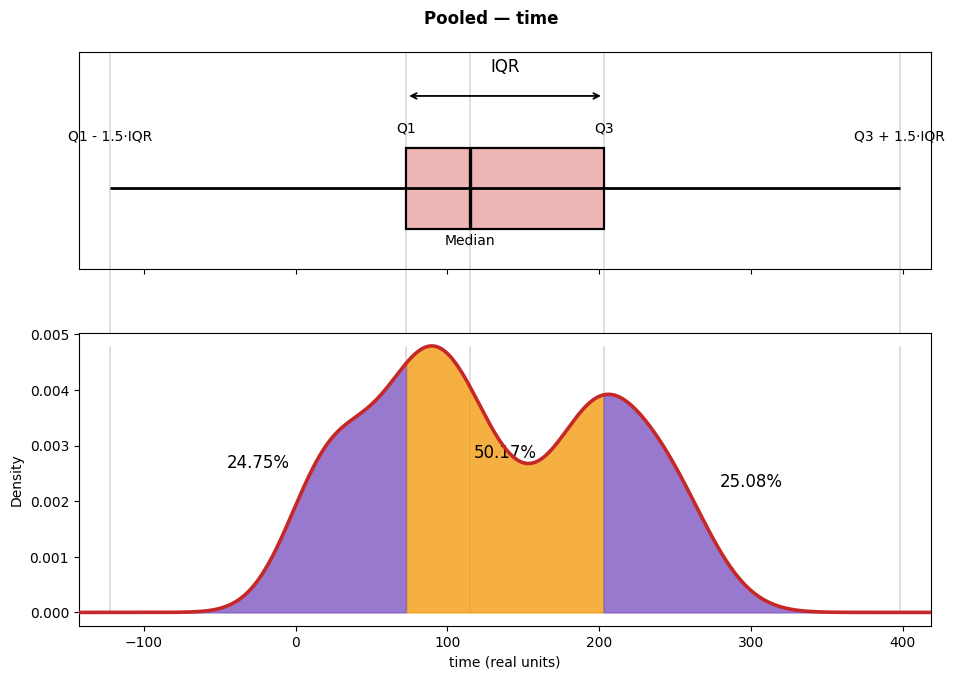

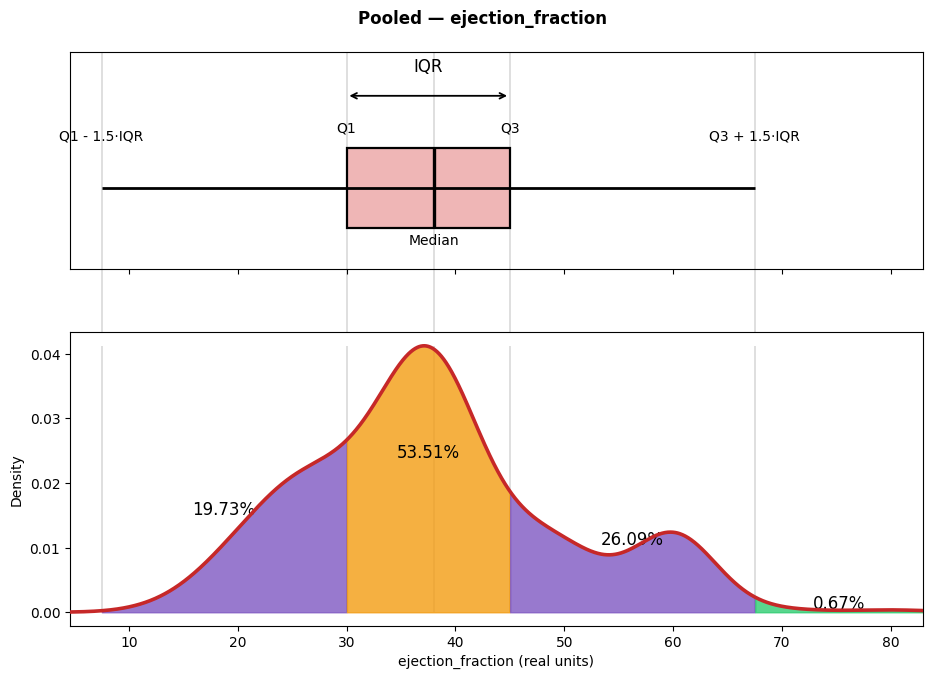

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

# ---------------- Helpers ----------------
def _x_to_figfrac(fig, ax, x):
    xd = ax.transData.transform((x, 0))[0]
    return fig.transFigure.inverted().transform((xd, 0))[0]

def _connect_vertical_lines(fig, ax_top, ax_bot, xs, color='0.80', lw=1.3):
    p_top, p_bot = ax_top.get_position(), ax_bot.get_position()
    y_top_bottom = p_top.y0
    y_bot_top    = p_bot.y1
    for x in xs:
        xf = _x_to_figfrac(fig, ax_top, x)
        fig.add_artist(Line2D([xf, xf], [y_bot_top, y_top_bottom],
                              transform=fig.transFigure, color=color, lw=lw, zorder=0))

def _pct(p):
    return f"{100*p:.2f}%"

# ---------------- Core plot ----------------
def plot_feature_real_distribution(dfx, variable, suptitle=None):
    x = dfx[variable].dropna().astype(float).values
    if x.size < 5:
        print(f"⚠️ {variable}: yeterli gözlem yok.")
        return

    # Gerçek özetler
    Q1, MED, Q3 = np.percentile(x, [25, 50, 75])
    IQR = Q3 - Q1
    LW, UW = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    xmin, xmax = min(x.min(), LW), max(x.max(), UW)
    pad = 0.04*(xmax - xmin) if xmax > xmin else 1.0
    xmin -= pad; xmax += pad

    # KDE (Scott kuralı; ekstra düzleştirme yok)
    kde = gaussian_kde(x, bw_method='scott')
    xs  = np.linspace(xmin, xmax, 1500)
    ys  = kde(xs)
    ys /= np.trapz(ys, xs)  # alan=1

    # Empirik bölge oranları
    p_left  = (x <  LW).mean()
    p_q1    = ((x >= LW) & (x < Q1)).mean()
    p_mid   = ((x >= Q1) & (x < Q3)).mean()
    p_q3    = ((x >= Q3) & (x < UW)).mean()
    p_right = (x >= UW).mean()

    regions = [
        (-np.inf, LW, '#2ecc71', p_left),
        (LW, Q1,   '#7e57c2', p_q1),
        (Q1, Q3,   '#f39c12', p_mid),
        (Q3, UW,   '#7e57c2', p_q3),
        (UW, np.inf,'#2ecc71', p_right),
    ]

    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(11, 7),
        gridspec_kw={"height_ratios":[1, 1.35]},
        sharex=True
    )
    plt.subplots_adjust(hspace=0.25, top=0.92, bottom=0.10)

    # --- Üst panel (box şema) ---
    seams = [LW, Q1, MED, Q3, UW]
    for v in seams:
        ax_top.vlines(v, -0.20, 0.34, color='0.85', lw=1.2, zorder=0)

    ax_top.hlines(0, LW, UW, color='black', lw=2.0)
    ax_top.add_patch(Rectangle((Q1, -0.10), Q3-Q1, 0.20,
                               facecolor='#efb6b6', edgecolor='black', lw=1.6))
    ax_top.vlines(MED, -0.10, 0.10, color='black', lw=2.4)

    ax_top.annotate('', xy=(Q1, 0.23), xytext=(Q3, 0.23),
                    arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'))
    ax_top.text((Q1+Q3)/2, 0.28, "IQR", ha='center', va='bottom', fontsize=12)
    ax_top.text(Q1,  0.14, "Q1", ha='center')
    ax_top.text(Q3,  0.14, "Q3", ha='center')
    ax_top.text(MED, -0.14, "Median", ha='center')
    ax_top.text(LW,  0.12, "Q1 - 1.5·IQR", ha='center')
    ax_top.text(UW,  0.12, "Q3 + 1.5·IQR", ha='center')

    ax_top.set_xlim(xmin, xmax)
    ax_top.set_ylim(-0.20, 0.34)
    ax_top.set_yticks([])
    for s in ax_top.spines.values(): s.set_visible(True)

    # --- Alt panel (KDE + bölgeler) ---
    ax_bot.plot(xs, ys, lw=2.6, color='#c62828', zorder=5)
    y_max = ys.max()

    for (a,b,c,p) in regions:
        xl, xr = max(xmin,a), min(xmax,b)
        mask = (xs >= xl) & (xs <= xr)
        if mask.any() and p > 0:
            ax_bot.fill_between(xs[mask], 0, ys[mask], color=c, alpha=0.80, zorder=2)
            xm = (xl + xr) / 2
            y_reg = ys[mask].max()
            ax_bot.text(xm, 0.60*y_reg, _pct(p), ha='center', va='center', fontsize=12)

    for v in seams:
        ax_bot.vlines(v, 0, y_max, color='0.85', lw=1.2, zorder=1)

    ax_bot.set_xlim(xmin, xmax)
    ax_bot.set_xlabel(f"{variable} (real units)")
    ax_bot.set_ylabel("Density")
    for s in ax_bot.spines.values(): s.set_visible(True)

    # Paneller arası dikey çizgileri birleştir
    _connect_vertical_lines(fig, ax_top, ax_bot, seams, color='0.85', lw=1.2)

    fig.suptitle(suptitle or f"Boxplot & Distribution — {variable}", weight='bold')
    plt.show()

# ---------------- Run (pooled over all clusters) ----------------
# 1) Veri: dfc zaten bellekteyse onu kullan, yoksa CSV'den oku
try:
    dfc  # noqa
except NameError:
    dfc = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Tüm kümeler birlikte (pooled) — time ve ejection_fraction
plot_feature_real_distribution(dfc, variable='time',               suptitle="Pooled — time")
plot_feature_real_distribution(dfc, variable='ejection_fraction', suptitle="Pooled — ejection_fraction")


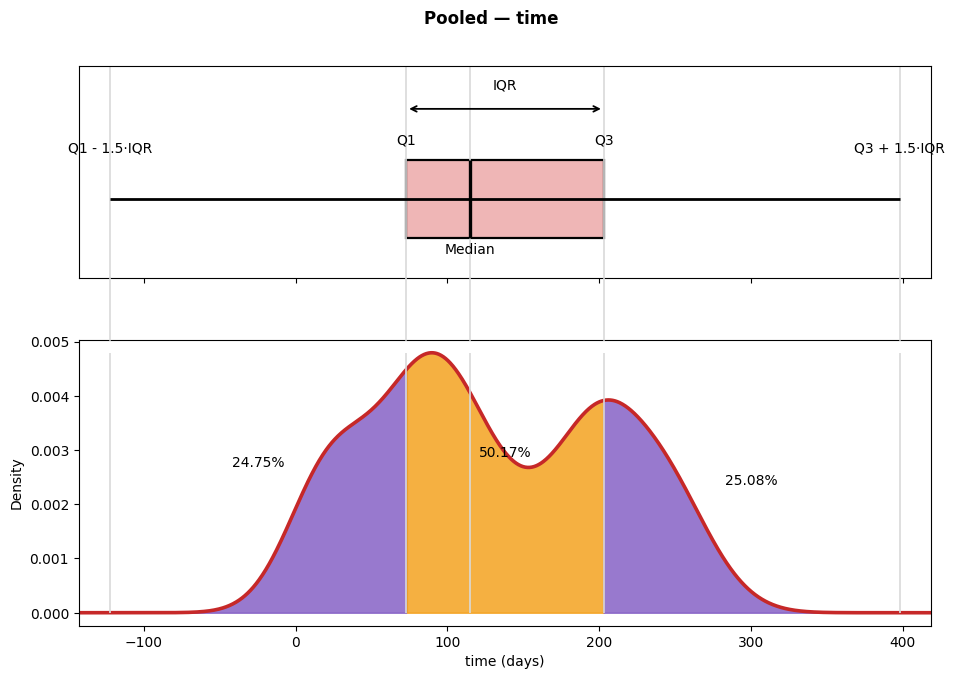

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

x = pd.to_numeric(df["time"], errors="coerce").dropna().values.astype(float)
x.sort()
Q1, MED, Q3 = np.percentile(x, [25,50,75]); IQR = Q3-Q1
LW, UW = Q1-1.5*IQR, Q3+1.5*IQR
xmin, xmax = min(x.min(), LW), max(x.max(), UW); pad = 0.04*(xmax-xmin); xmin-=pad; xmax+=pad
kde = gaussian_kde(x, bw_method='scott'); xs = np.linspace(xmin, xmax, 1500); ys = kde(xs); ys/=np.trapz(ys,xs)
pL=(x<LW).mean(); pQ1=((x>=LW)&(x<Q1)).mean(); pMID=((x>=Q1)&(x<Q3)).mean(); pQ3=((x>=Q3)&(x<=UW)).mean(); pR=(x>UW).mean()

fig,(ax0,ax1)=plt.subplots(2,1,figsize=(11,7),gridspec_kw={"height_ratios":[1,1.35]},sharex=True)
plt.subplots_adjust(hspace=.25,top=.9,bottom=.1)
seams=[LW,Q1,MED,Q3,UW]
for v in seams: ax0.vlines(v,-.2,.34,color='0.85',lw=1.2)
ax0.hlines(0,LW,UW,color='black',lw=2.0)
ax0.add_patch(Rectangle((Q1,-.10),Q3-Q1,.20,facecolor='#efb6b6',edgecolor='black',lw=1.6))
ax0.vlines(MED,-.10,.10,color='black',lw=2.4)
ax0.annotate('',xy=(Q1,.23),xytext=(Q3,.23),arrowprops=dict(arrowstyle='<->',lw=1.3,color='black'))
ax0.text((Q1+Q3)/2,.28,"IQR",ha='center'); ax0.text(Q1,.14,"Q1",ha='center'); ax0.text(Q3,.14,"Q3",ha='center')
ax0.text(MED,-.14,"Median",ha='center'); ax0.text(LW,.12,"Q1 - 1.5·IQR",ha='center'); ax0.text(UW,.12,"Q3 + 1.5·IQR",ha='center')
ax0.set_yticks([]); ax0.set_xlim(xmin,xmax); ax0.set_ylim(-.2,.34)

ax1.plot(xs,ys,lw=2.6,color='#c62828'); yM=ys.max()
def fill(a,b,c,p):
    xl,xr=max(xmin,a),min(xmax,b); m=(xs>=xl)&(xs<=xr)
    if m.any() and p>0: ax1.fill_between(xs[m],0,ys[m],color=c,alpha=.80); ax1.text((xl+xr)/2,0.6*ys[m].max(),f"{100*p:.2f}%",ha='center')
for (a,b,c,p) in [(-np.inf,LW,'#2ecc71',pL),(LW,Q1,'#7e57c2',pQ1),(Q1,Q3,'#f39c12',pMID),(Q3,UW,'#7e57c2',pQ3),(UW,np.inf,'#2ecc71',pR)]: fill(a,b,c,p)
for v in seams: ax1.vlines(v,0,yM,color='0.85',lw=1.2)
ax1.set_xlim(xmin,xmax); ax1.set_xlabel("time (days)"); ax1.set_ylabel("Density")

def _x_to_figfrac(fig,ax,xv): return fig.transFigure.inverted().transform((ax.transData.transform((xv,0))[0],0))[0]
for xv in seams:
    xf=_x_to_figfrac(fig,ax0,xv); fig.add_artist(Line2D([xf,xf],[ax1.get_position().y1,ax0.get_position().y0],transform=fig.transFigure,color='0.85',lw=1.2))
fig.suptitle("Pooled — time",weight='bold'); plt.show()


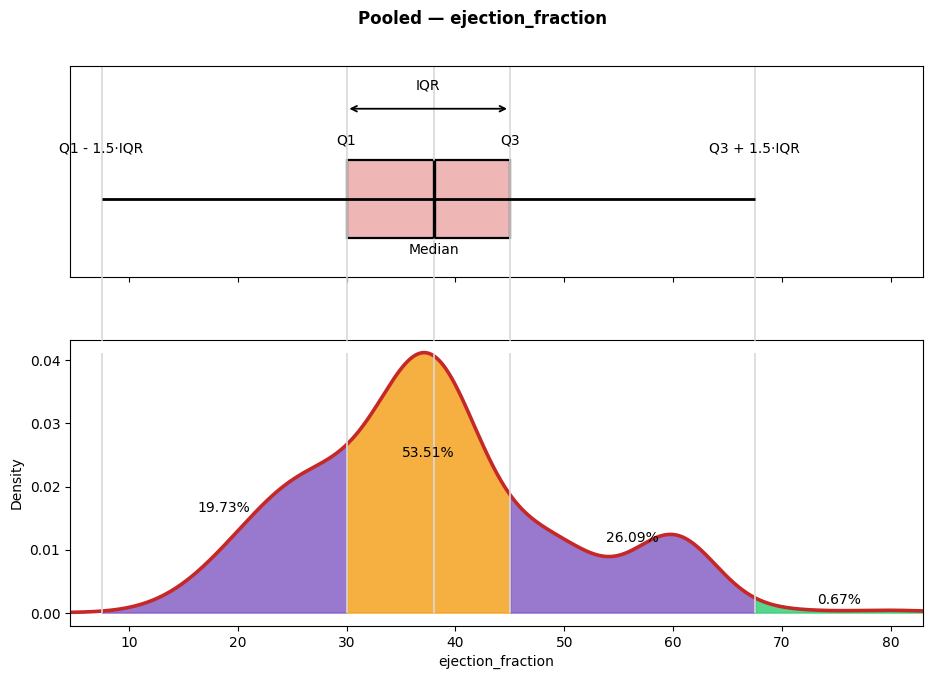

In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle; from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

x = pd.to_numeric(df["ejection_fraction"], errors="coerce").dropna().values.astype(float); x.sort()
Q1,MED,Q3=np.percentile(x,[25,50,75]); IQR=Q3-Q1; LW,QW=Q1-1.5*IQR,Q3+1.5*IQR
xmin,xmax=min(x.min(),LW),max(x.max(),QW); pad=.04*(xmax-xmin); xmin-=pad; xmax+=pad
kde=gaussian_kde(x,'scott'); xs=np.linspace(xmin,xmax,1500); ys=kde(xs); ys/=np.trapz(ys,xs)
pL=(x<LW).mean(); pQ1=((x>=LW)&(x<Q1)).mean(); pMID=((x>=Q1)&(x<Q3)).mean(); pQ3=((x>=Q3)&(x<=QW)).mean(); pR=(x>QW).mean()

fig,(ax0,ax1)=plt.subplots(2,1,figsize=(11,7),gridspec_kw={"height_ratios":[1,1.35]},sharex=True)
plt.subplots_adjust(hspace=.25,top=.9,bottom=.1)
seams=[LW,Q1,MED,Q3,QW]
for v in seams: ax0.vlines(v,-.2,.34,color='0.85',lw=1.2)
ax0.hlines(0,LW,QW,color='black',lw=2.0)
ax0.add_patch(Rectangle((Q1,-.10),Q3-Q1,.20,facecolor='#efb6b6',edgecolor='black',lw=1.6))
ax0.vlines(MED,-.10,.10,color='black',lw=2.4)
ax0.annotate('',xy=(Q1,.23),xytext=(Q3,.23),arrowprops=dict(arrowstyle='<->',lw=1.3,color='black'))
ax0.text((Q1+Q3)/2,.28,"IQR",ha='center'); ax0.text(Q1,.14,"Q1",ha='center'); ax0.text(Q3,.14,"Q3",ha='center')
ax0.text(MED,-.14,"Median",ha='center'); ax0.text(LW,.12,"Q1 - 1.5·IQR",ha='center'); ax0.text(QW,.12,"Q3 + 1.5·IQR",ha='center')
ax0.set_yticks([]); ax0.set_xlim(xmin,xmax); ax0.set_ylim(-.2,.34)

ax1.plot(xs,ys,lw=2.6,color='#c62828'); yM=ys.max()
def fill(a,b,c,p):
    xl,xr=max(xmin,a),min(xmax,b); m=(xs>=xl)&(xs<=xr)
    if m.any() and p>0: ax1.fill_between(xs[m],0,ys[m],color=c,alpha=.80); ax1.text((xl+xr)/2,0.6*ys[m].max(),f"{100*p:.2f}%",ha='center')
for (a,b,c,p) in [(-np.inf,LW,'#2ecc71',pL),(LW,Q1,'#7e57c2',pQ1),(Q1,Q3,'#f39c12',pMID),(Q3,QW,'#7e57c2',pQ3),(QW,np.inf,'#2ecc71',pR)]: fill(a,b,c,p)
for v in seams: ax1.vlines(v,0,yM,color='0.85',lw=1.2)
ax1.set_xlim(xmin,xmax); ax1.set_xlabel("ejection_fraction"); ax1.set_ylabel("Density")

def _x_to_figfrac(fig,ax,xv): return fig.transFigure.inverted().transform((ax.transData.transform((xv,0))[0],0))[0]
for xv in seams:
    xf=_x_to_figfrac(fig,ax0,xv); fig.add_artist(Line2D([xf,xf],[ax1.get_position().y1,ax0.get_position().y0],transform=fig.transFigure,color='0.85',lw=1.2))
fig.suptitle("Pooled — ejection_fraction",weight='bold'); plt.show()


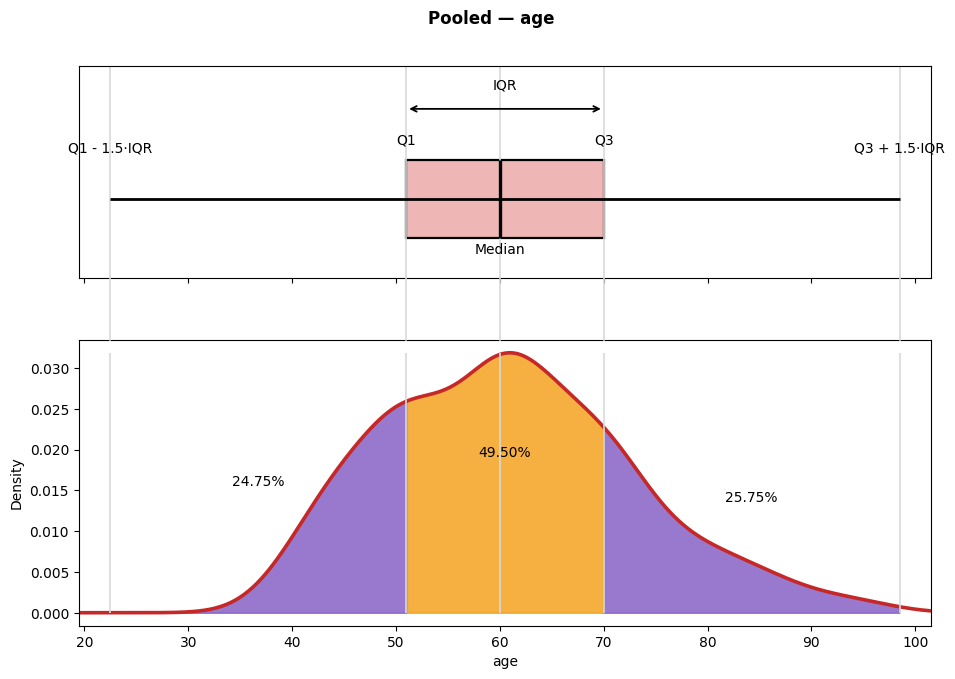

In [11]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle; from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

x=pd.to_numeric(df["age"],errors="coerce").dropna().values.astype(float); x.sort()
Q1,MED,Q3=np.percentile(x,[25,50,75]); IQR=Q3-Q1; LW,UW=Q1-1.5*IQR,Q3+1.5*IQR
xmin,xmax=min(x.min(),LW),max(x.max(),UW); pad=.04*(xmax-xmin); xmin-=pad; xmax+=pad
kde=gaussian_kde(x,'scott'); xs=np.linspace(xmin,xmax,1500); ys=kde(xs); ys/=np.trapz(ys,xs)
pL=(x<LW).mean(); pQ1=((x>=LW)&(x<Q1)).mean(); pMID=((x>=Q1)&(x<Q3)).mean(); pQ3=((x>=Q3)&(x<=UW)).mean(); pR=(x>UW).mean()

fig,(ax0,ax1)=plt.subplots(2,1,figsize=(11,7),gridspec_kw={"height_ratios":[1,1.35]},sharex=True)
plt.subplots_adjust(hspace=.25,top=.9,bottom=.1)
seams=[LW,Q1,MED,Q3,UW]
for v in seams: ax0.vlines(v,-.2,.34,color='0.85',lw=1.2)
ax0.hlines(0,LW,UW,color='black',lw=2.0)
ax0.add_patch(Rectangle((Q1,-.10),Q3-Q1,.20,facecolor='#efb6b6',edgecolor='black',lw=1.6))
ax0.vlines(MED,-.10,.10,color='black',lw=2.4)
ax0.annotate('',xy=(Q1,.23),xytext=(Q3,.23),arrowprops=dict(arrowstyle='<->',lw=1.3,color='black'))
ax0.text((Q1+Q3)/2,.28,"IQR",ha='center'); ax0.text(Q1,.14,"Q1",ha='center'); ax0.text(Q3,.14,"Q3",ha='center')
ax0.text(MED,-.14,"Median",ha='center'); ax0.text(LW,.12,"Q1 - 1.5·IQR",ha='center'); ax0.text(UW,.12,"Q3 + 1.5·IQR",ha='center')
ax0.set_yticks([]); ax0.set_xlim(xmin,xmax); ax0.set_ylim(-.2,.34)

ax1.plot(xs,ys,lw=2.6,color='#c62828'); yM=ys.max()
def fill(a,b,c,p):
    xl,xr=max(xmin,a),min(xmax,b); m=(xs>=xl)&(xs<=xr)
    if m.any() and p>0: ax1.fill_between(xs[m],0,ys[m],color=c,alpha=.80); ax1.text((xl+xr)/2,0.6*ys[m].max(),f"{100*p:.2f}%",ha='center')
for (a,b,c,p) in [(-np.inf,LW,'#2ecc71',pL),(LW,Q1,'#7e57c2',pQ1),(Q1,Q3,'#f39c12',pMID),(Q3,UW,'#7e57c2',pQ3),(UW,np.inf,'#2ecc71',pR)]: fill(a,b,c,p)
for v in seams: ax1.vlines(v,0,yM,color='0.85',lw=1.2)
ax1.set_xlim(xmin,xmax); ax1.set_xlabel("age"); ax1.set_ylabel("Density")

def _x_to_figfrac(fig,ax,xv): return fig.transFigure.inverted().transform((ax.transData.transform((xv,0))[0],0))[0]
for xv in seams:
    xf=_x_to_figfrac(fig,ax0,xv); fig.add_artist(Line2D([xf,xf],[ax1.get_position().y1,ax0.get_position().y0],transform=fig.transFigure,color='0.85',lw=1.2))
fig.suptitle("Pooled — age",weight='bold'); plt.show()


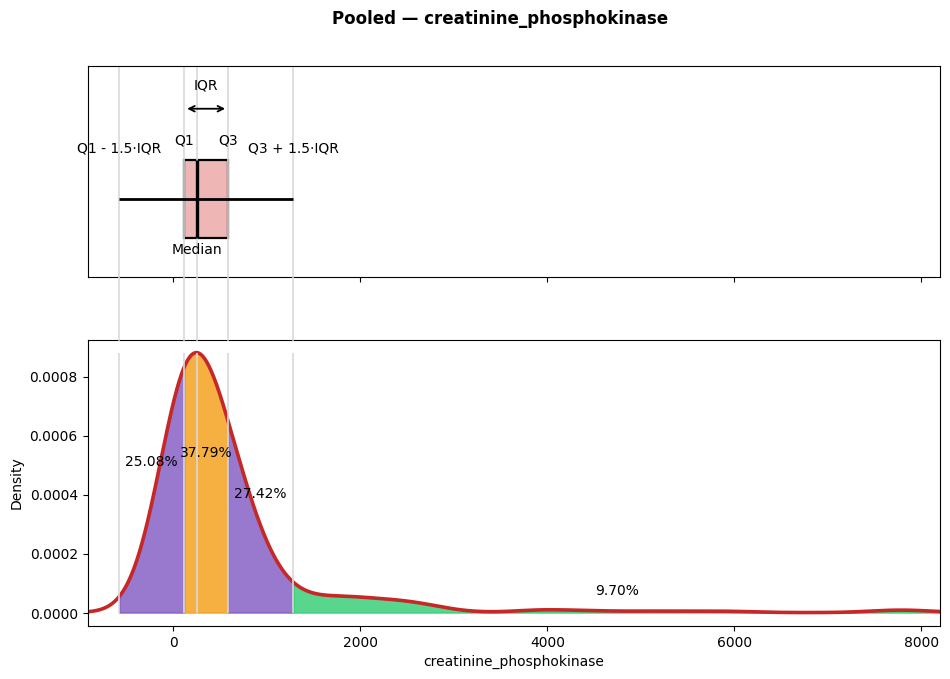

In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle; from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

x=pd.to_numeric(df["creatinine_phosphokinase"],errors="coerce").dropna().values.astype(float); x.sort()
Q1,MED,Q3=np.percentile(x,[25,50,75]); IQR=Q3-Q1; LW,UW=Q1-1.5*IQR,Q3+1.5*IQR
xmin,xmax=min(x.min(),LW),max(x.max(),UW); pad=.04*(xmax-xmin); xmin-=pad; xmax+=pad
kde=gaussian_kde(x,'scott'); xs=np.linspace(xmin,xmax,1500); ys=kde(xs); ys/=np.trapz(ys,xs)
pL=(x<LW).mean(); pQ1=((x>=LW)&(x<Q1)).mean(); pMID=((x>=Q1)&(x<Q3)).mean(); pQ3=((x>=Q3)&(x<=UW)).mean(); pR=(x>UW).mean()

fig,(ax0,ax1)=plt.subplots(2,1,figsize=(11,7),gridspec_kw={"height_ratios":[1,1.35]},sharex=True)
plt.subplots_adjust(hspace=.25,top=.9,bottom=.1)
seams=[LW,Q1,MED,Q3,UW]
for v in seams: ax0.vlines(v,-.2,.34,color='0.85',lw=1.2)
ax0.hlines(0,LW,UW,color='black',lw=2.0)
ax0.add_patch(Rectangle((Q1,-.10),Q3-Q1,.20,facecolor='#efb6b6',edgecolor='black',lw=1.6))
ax0.vlines(MED,-.10,.10,color='black',lw=2.4)
ax0.annotate('',xy=(Q1,.23),xytext=(Q3,.23),arrowprops=dict(arrowstyle='<->',lw=1.3,color='black'))
ax0.text((Q1+Q3)/2,.28,"IQR",ha='center'); ax0.text(Q1,.14,"Q1",ha='center'); ax0.text(Q3,.14,"Q3",ha='center')
ax0.text(MED,-.14,"Median",ha='center'); ax0.text(LW,.12,"Q1 - 1.5·IQR",ha='center'); ax0.text(UW,.12,"Q3 + 1.5·IQR",ha='center')
ax0.set_yticks([]); ax0.set_xlim(xmin,xmax); ax0.set_ylim(-.2,.34)

ax1.plot(xs,ys,lw=2.6,color='#c62828'); yM=ys.max()
def fill(a,b,c,p):
    xl,xr=max(xmin,a),min(xmax,b); m=(xs>=xl)&(xs<=xr)
    if m.any() and p>0: ax1.fill_between(xs[m],0,ys[m],color=c,alpha=.80); ax1.text((xl+xr)/2,0.6*ys[m].max(),f"{100*p:.2f}%",ha='center')
for (a,b,c,p) in [(-np.inf,LW,'#2ecc71',pL),(LW,Q1,'#7e57c2',pQ1),(Q1,Q3,'#f39c12',pMID),(Q3,UW,'#7e57c2',pQ3),(UW,np.inf,'#2ecc71',pR)]: fill(a,b,c,p)
for v in seams: ax1.vlines(v,0,yM,color='0.85',lw=1.2)
ax1.set_xlim(xmin,xmax); ax1.set_xlabel("creatinine_phosphokinase"); ax1.set_ylabel("Density")

def _x_to_figfrac(fig,ax,xv): return fig.transFigure.inverted().transform((ax.transData.transform((xv,0))[0],0))[0]
for xv in seams:
    xf=_x_to_figfrac(fig,ax0,xv); fig.add_artist(Line2D([xf,xf],[ax1.get_position().y1,ax0.get_position().y0],transform=fig.transFigure,color='0.85',lw=1.2))
fig.suptitle("Pooled — creatinine_phosphokinase",weight='bold'); plt.show()


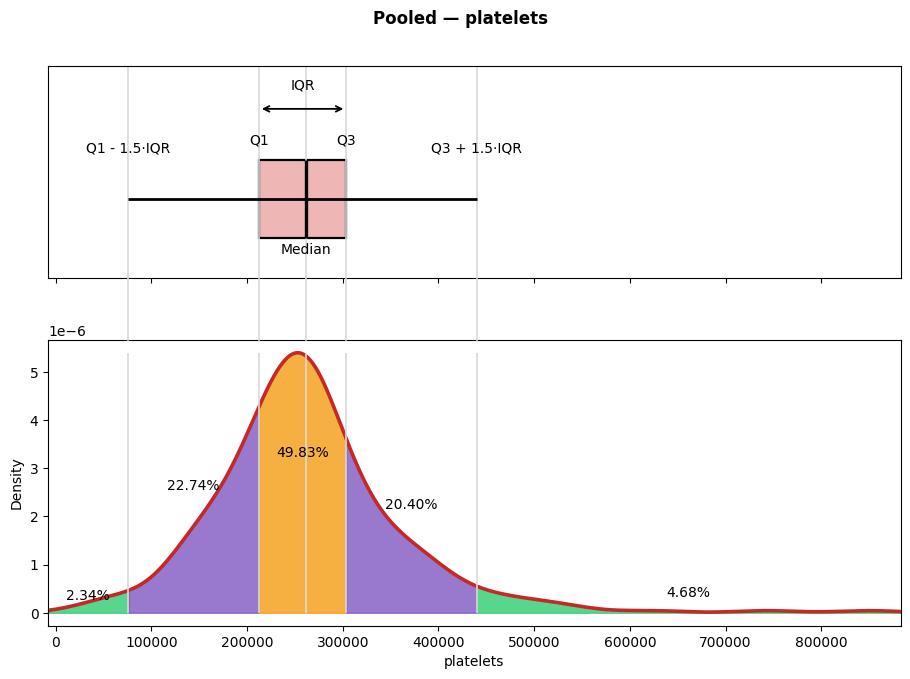

In [13]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle; from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

x=pd.to_numeric(df["platelets"],errors="coerce").dropna().values.astype(float); x.sort()
Q1,MED,Q3=np.percentile(x,[25,50,75]); IQR=Q3-Q1; LW,UW=Q1-1.5*IQR,Q3+1.5*IQR
xmin,xmax=min(x.min(),LW),max(x.max(),UW); pad=.04*(xmax-xmin); xmin-=pad; xmax+=pad
kde=gaussian_kde(x,'scott'); xs=np.linspace(xmin,xmax,1500); ys=kde(xs); ys/=np.trapz(ys,xs)
pL=(x<LW).mean(); pQ1=((x>=LW)&(x<Q1)).mean(); pMID=((x>=Q1)&(x<Q3)).mean(); pQ3=((x>=Q3)&(x<=UW)).mean(); pR=(x>UW).mean()

fig,(ax0,ax1)=plt.subplots(2,1,figsize=(11,7),gridspec_kw={"height_ratios":[1,1.35]},sharex=True)
plt.subplots_adjust(hspace=.25,top=.9,bottom=.1)
seams=[LW,Q1,MED,Q3,UW]
for v in seams: ax0.vlines(v,-.2,.34,color='0.85',lw=1.2)
ax0.hlines(0,LW,UW,color='black',lw=2.0)
ax0.add_patch(Rectangle((Q1,-.10),Q3-Q1,.20,facecolor='#efb6b6',edgecolor='black',lw=1.6))
ax0.vlines(MED,-.10,.10,color='black',lw=2.4)
ax0.annotate('',xy=(Q1,.23),xytext=(Q3,.23),arrowprops=dict(arrowstyle='<->',lw=1.3,color='black'))
ax0.text((Q1+Q3)/2,.28,"IQR",ha='center'); ax0.text(Q1,.14,"Q1",ha='center'); ax0.text(Q3,.14,"Q3",ha='center')
ax0.text(MED,-.14,"Median",ha='center'); ax0.text(LW,.12,"Q1 - 1.5·IQR",ha='center'); ax0.text(UW,.12,"Q3 + 1.5·IQR",ha='center')
ax0.set_yticks([]); ax0.set_xlim(xmin,xmax); ax0.set_ylim(-.2,.34)

ax1.plot(xs,ys,lw=2.6,color='#c62828'); yM=ys.max()
def fill(a,b,c,p):
    xl,xr=max(xmin,a),min(xmax,b); m=(xs>=xl)&(xs<=xr)
    if m.any() and p>0: ax1.fill_between(xs[m],0,ys[m],color=c,alpha=.80); ax1.text((xl+xr)/2,0.6*ys[m].max(),f"{100*p:.2f}%",ha='center')
for (a,b,c,p) in [(-np.inf,LW,'#2ecc71',pL),(LW,Q1,'#7e57c2',pQ1),(Q1,Q3,'#f39c12',pMID),(Q3,UW,'#7e57c2',pQ3),(UW,np.inf,'#2ecc71',pR)]: fill(a,b,c,p)
for v in seams: ax1.vlines(v,0,yM,color='0.85',lw=1.2)
ax1.set_xlim(xmin,xmax); ax1.set_xlabel("platelets"); ax1.set_ylabel("Density")

def _x_to_figfrac(fig,ax,xv): return fig.transFigure.inverted().transform((ax.transData.transform((xv,0))[0],0))[0]
for xv in seams:
    xf=_x_to_figfrac(fig,ax0,xv); fig.add_artist(Line2D([xf,xf],[ax1.get_position().y1,ax0.get_position().y0],transform=fig.transFigure,color='0.85',lw=1.2))
fig.suptitle("Pooled — platelets",weight='bold'); plt.show()


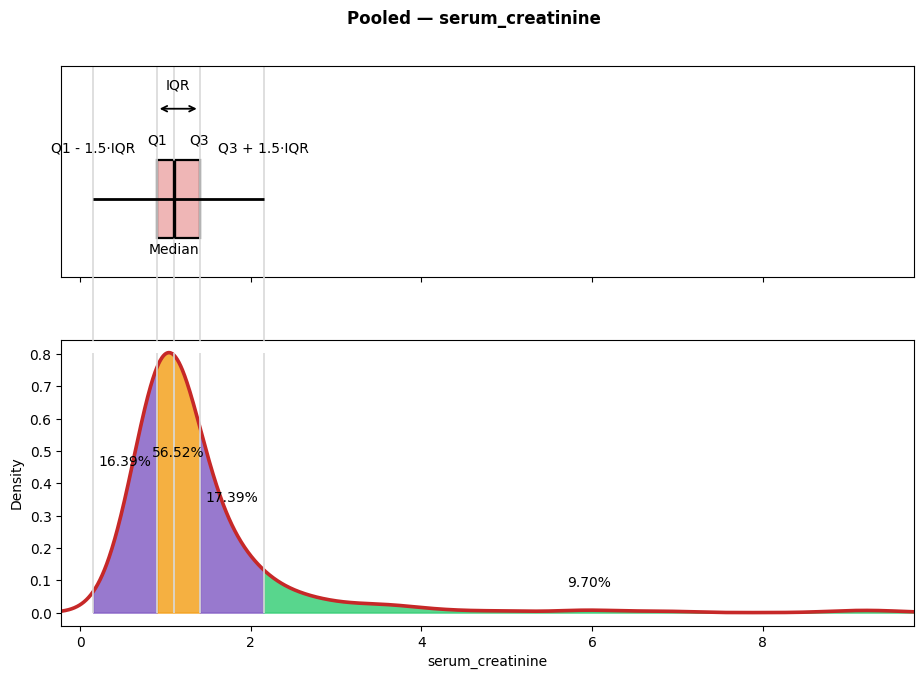

In [14]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle; from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

x=pd.to_numeric(df["serum_creatinine"],errors="coerce").dropna().values.astype(float); x.sort()
Q1,MED,Q3=np.percentile(x,[25,50,75]); IQR=Q3-Q1; LW,UW=Q1-1.5*IQR,Q3+1.5*IQR
xmin,xmax=min(x.min(),LW),max(x.max(),UW); pad=.04*(xmax-xmin); xmin-=pad; xmax+=pad
kde=gaussian_kde(x,'scott'); xs=np.linspace(xmin,xmax,1500); ys=kde(xs); ys/=np.trapz(ys,xs)
pL=(x<LW).mean(); pQ1=((x>=LW)&(x<Q1)).mean(); pMID=((x>=Q1)&(x<Q3)).mean(); pQ3=((x>=Q3)&(x<=UW)).mean(); pR=(x>UW).mean()

fig,(ax0,ax1)=plt.subplots(2,1,figsize=(11,7),gridspec_kw={"height_ratios":[1,1.35]},sharex=True)
plt.subplots_adjust(hspace=.25,top=.9,bottom=.1)
seams=[LW,Q1,MED,Q3,UW]
for v in seams: ax0.vlines(v,-.2,.34,color='0.85',lw=1.2)
ax0.hlines(0,LW,UW,color='black',lw=2.0)
ax0.add_patch(Rectangle((Q1,-.10),Q3-Q1,.20,facecolor='#efb6b6',edgecolor='black',lw=1.6))
ax0.vlines(MED,-.10,.10,color='black',lw=2.4)
ax0.annotate('',xy=(Q1,.23),xytext=(Q3,.23),arrowprops=dict(arrowstyle='<->',lw=1.3,color='black'))
ax0.text((Q1+Q3)/2,.28,"IQR",ha='center'); ax0.text(Q1,.14,"Q1",ha='center'); ax0.text(Q3,.14,"Q3",ha='center')
ax0.text(MED,-.14,"Median",ha='center'); ax0.text(LW,.12,"Q1 - 1.5·IQR",ha='center'); ax0.text(UW,.12,"Q3 + 1.5·IQR",ha='center')
ax0.set_yticks([]); ax0.set_xlim(xmin,xmax); ax0.set_ylim(-.2,.34)

ax1.plot(xs,ys,lw=2.6,color='#c62828'); yM=ys.max()
def fill(a,b,c,p):
    xl,xr=max(xmin,a),min(xmax,b); m=(xs>=xl)&(xs<=xr)
    if m.any() and p>0: ax1.fill_between(xs[m],0,ys[m],color=c,alpha=.80); ax1.text((xl+xr)/2,0.6*ys[m].max(),f"{100*p:.2f}%",ha='center')
for (a,b,c,p) in [(-np.inf,LW,'#2ecc71',pL),(LW,Q1,'#7e57c2',pQ1),(Q1,Q3,'#f39c12',pMID),(Q3,UW,'#7e57c2',pQ3),(UW,np.inf,'#2ecc71',pR)]: fill(a,b,c,p)
for v in seams: ax1.vlines(v,0,yM,color='0.85',lw=1.2)
ax1.set_xlim(xmin,xmax); ax1.set_xlabel("serum_creatinine"); ax1.set_ylabel("Density")

def _x_to_figfrac(fig,ax,xv): return fig.transFigure.inverted().transform((ax.transData.transform((xv,0))[0],0))[0]
for xv in seams:
    xf=_x_to_figfrac(fig,ax0,xv); fig.add_artist(Line2D([xf,xf],[ax1.get_position().y1,ax0.get_position().y0],transform=fig.transFigure,color='0.85',lw=1.2))
fig.suptitle("Pooled — serum_creatinine",weight='bold'); plt.show()


#### Cluster Means Heatmap

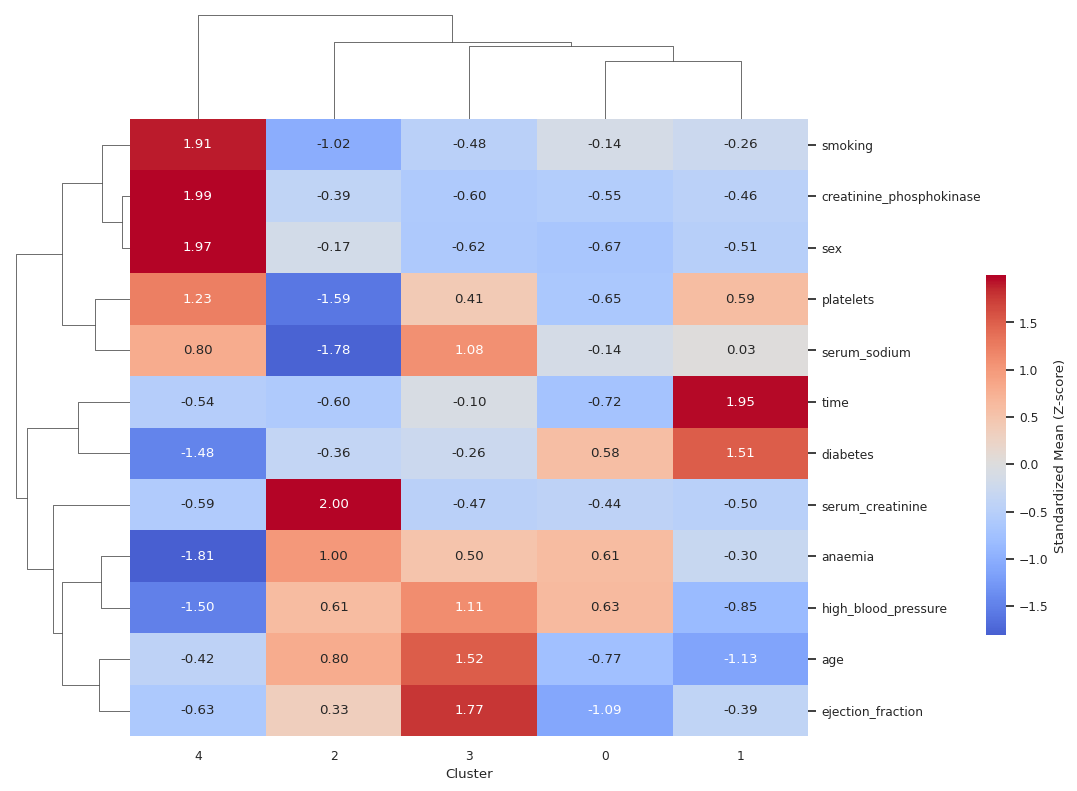

In [32]:
df_plot = dfc.copy()

cluster_means = df_plot.groupby('cluster')[continuous_cols + binary_cols].mean()

scaler = StandardScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    index=cluster_means.index,
    columns=cluster_means.columns
)

sns.set(font_scale=0.8)

cg = sns.clustermap(
    cluster_means_scaled.T,
    cmap='coolwarm',
    linewidths=0,
    linecolor='gray',
    center=0,
    figsize=(10,8),
    annot=True,
    fmt=".2f",
    dendrogram_ratio=(0.15, 0.15),
    cbar_kws={'label': 'Standardized Mean (Z-score)', 'shrink': 0.6},
    col_cluster=True,
    row_cluster=True
)

cg.cax.set_position([.99, .2, .02, .45])  # [left, bottom, width, height]

cg.ax_heatmap.set_xlabel("Cluster")
cg.ax_heatmap.set_ylabel("Feature")
plt.title("", fontsize=12, pad=200)
plt.show()

#### Death Event Per Cluster

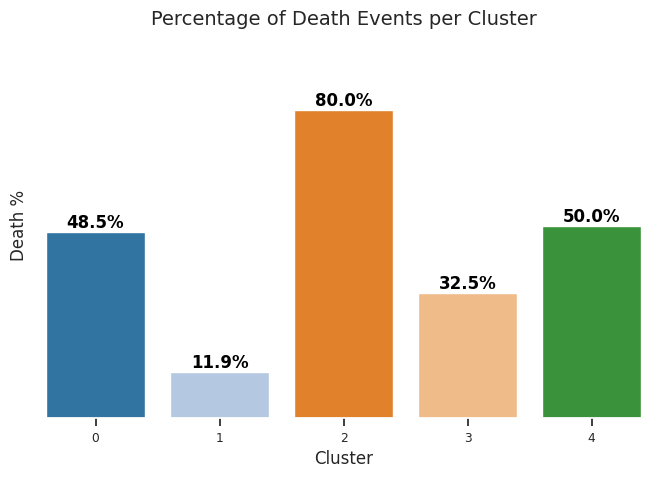

In [31]:
cluster_death_pct = dfc.groupby('cluster')['DEATH_EVENT'].mean() * 100

palette = sns.color_palette("tab20", len(cluster_death_pct))

plt.figure(figsize=(8,5))
bars = sns.barplot(
    x=cluster_death_pct.index,
    y=cluster_death_pct.values,
    palette=palette
)

for bar, pct in zip(bars.patches, cluster_death_pct.values):
    bars.annotate(f'{pct:.1f}%',
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title('Percentage of Death Events per Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Death %', fontsize=12)
plt.yticks([])
plt.ylim(0, 100)
plt.show()

#### PCA & UMAP

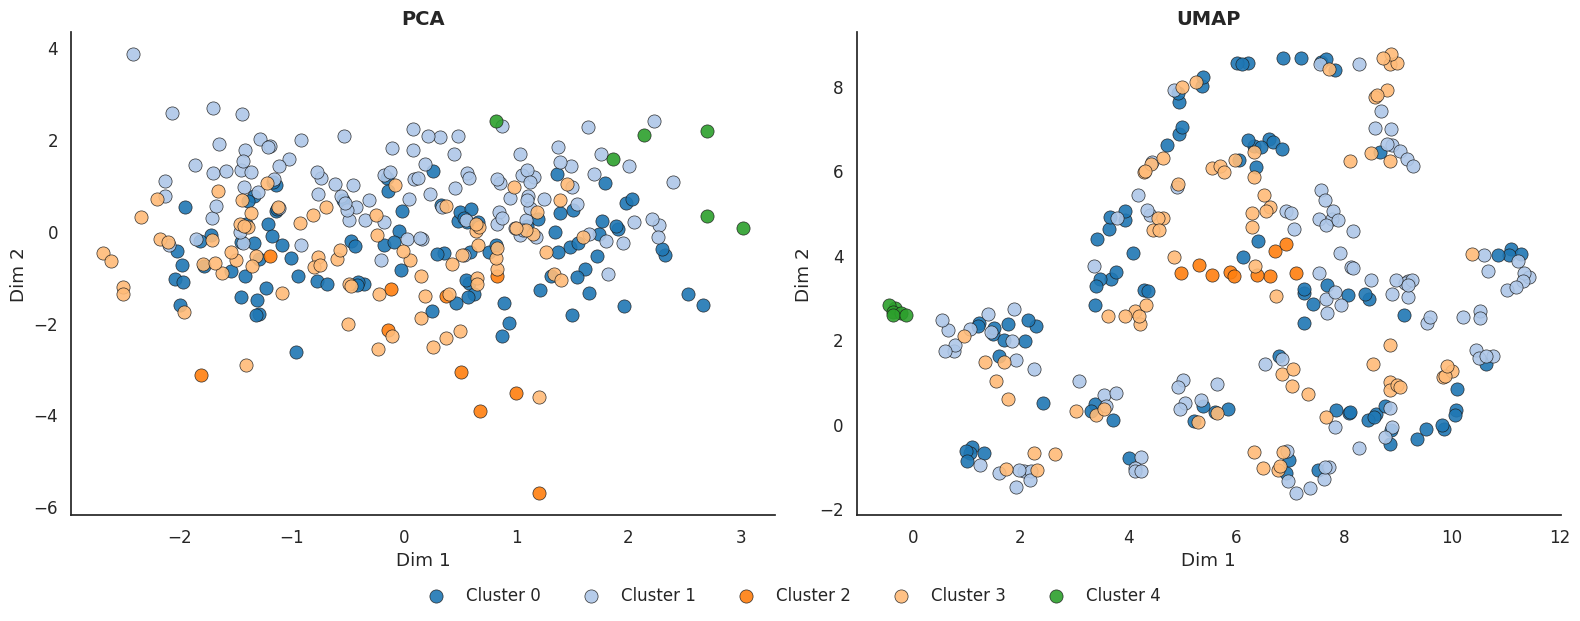

In [ ]:
X = dfc[feature_cols].values
y = dfc['cluster'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

umap_model = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=5,
    min_dist=0.3,
    metric='euclidean'
)
X_umap = umap_model.fit_transform(X_scaled)

sns.set(style="white", font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=False, sharey=False)

palette = sns.color_palette("tab20", len(set(y)))
color_map = {lab: palette[i % len(palette)] for i, lab in enumerate(sorted(set(y)))}

for ax, data, title in zip(axes, [X_pca, X_umap], ["PCA", "UMAP"]):
    for lab in sorted(set(y)):
        mask = y == lab
        ax.scatter(
            data[mask,0], data[mask,1],
            s=90,
            color=color_map[lab],
            alpha=0.9,
            edgecolors='k',
            linewidths=0.5,
            label=f"Cluster {lab}"
        )
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

fig.legend(
    [f"Cluster {i}" for i in sorted(set(y))],
    loc='lower center', ncol=len(set(y)),
    frameon=False, fontsize=12, bbox_to_anchor=(0.5, -0.05)
)

plt.tight_layout()
plt.show()

### 2. Test Differences

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

def anova_or_kw(dff, col, cl='cluster', nonparam=False):
    groups = [g[col].dropna().values for _, g in dff.groupby(cl)]
    if nonparam:
        stat, p = stats.kruskal(*groups)
        test = 'Kruskal-Wallis'
    else:
        stat, p = stats.f_oneway(*groups)
        test = 'ANOVA'
    return test, stat, p

def chi2_or_fisher(dff, col, cl='cluster', fisher_threshold=5):
    ct = pd.crosstab(dff[cl], dff[col])
    # Fisher sadece 2x2 için uygundur
    if (ct.values < fisher_threshold).any() and ct.shape == (2,2):
        _, p = stats.fisher_exact(ct.values)
        return 'Fisher (2x2)', None, p
    chi2, p, dof, exp = stats.chi2_contingency(ct, correction=False)
    return 'Chi-square', chi2, p

rows = []
for c in continuous_cols:
    t, st, p = anova_or_kw(dfc, c, nonparam=False)
    rows.append({'var': c, 'type': 'continuous', 'test': t, 'stat': st, 'p': p})

for c in binary_cols:
    t, st, p = chi2_or_fisher(dfc, c)
    rows.append({'var': c, 'type': 'binary', 'test': t, 'stat': st, 'p': p})

tests_df = pd.DataFrame(rows)
rej, p_adj, _, _ = multipletests(tests_df['p'].fillna(1.0).values, method='fdr_bh')
tests_df['p_adj'] = p_adj
tests_df['significant_FDR_0.05'] = rej
tests_df.sort_values('p_adj')


,var,type,test,stat,p,p_adj,significant_FDR_0.05
6,time,continuous,ANOVA,132.382671,1.668125e-64,2.001749e-63,True
1,creatinine_phosphokinase,continuous,ANOVA,123.212471,1.317595e-61,7.905570e-61,True
4,serum_creatinine,continuous,ANOVA,122.119281,2.979354e-61,1.191742e-60,True
2,ejection_fraction,continuous,ANOVA,66.220721,6.920515e-40,2.076155e-39,True
0,age,continuous,ANOVA,20.365937,7.992470e-15,1.918193e-14,True
7,anaemia,binary,Chi-square,15.122166,4.454429e-03,8.908858e-03,True
9,high_blood_pressure,binary,Chi-square,11.784496,1.902787e-02,3.261920e-02,True
8,diabetes,binary,Chi-square,10.653499,3.074699e-02,4.612049e-02,True
5,serum_sodium,continuous,ANOVA,2.081607,8.322158e-02,1.109621e-01,False
11,smoking,binary,Chi-square,4.564436,3.349752e-01,4.019703e-01,False


### 3. Multivariate Check

#### Permutation Importance

Random Forest accuracy predicting kmeans cluster labels: 0.922


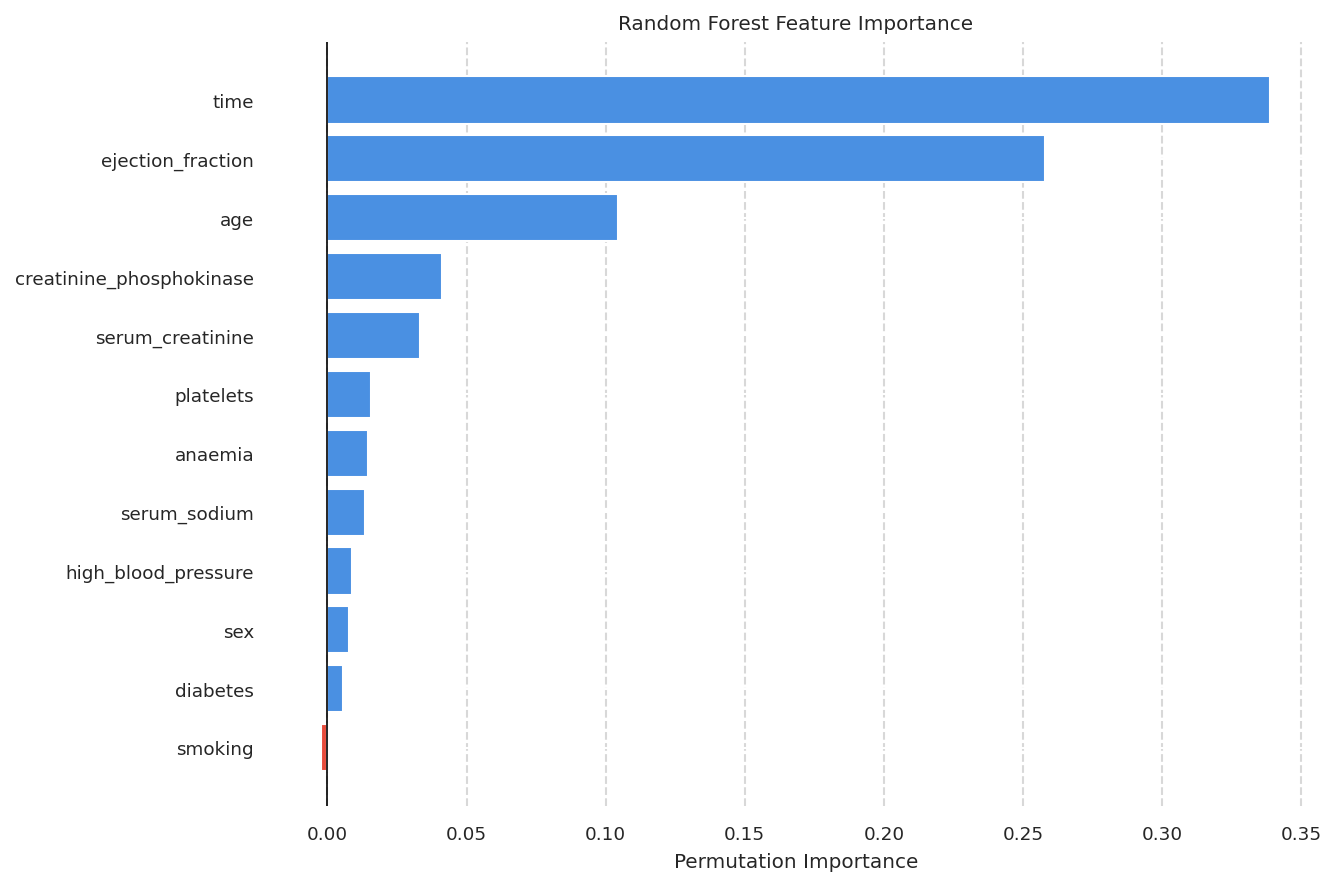

In [20]:
features = feature_cols
X = dfc[feature_cols].sort_index()
y = dfc['cluster'].sort_index()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

acc = rf.score(X_test, y_test)
print(f"Random Forest accuracy predicting kmeans cluster labels: {acc:.3f}")

perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_imp = pd.DataFrame({
    'Feature': feature_cols,
    'PermImportance': perm.importances_mean
})

perm_imp = perm_imp.sort_values('PermImportance')
colors = ['#4A90E2' if val >= 0 else '#E74C3C' for val in perm_imp['PermImportance']]

plt.figure(figsize=(9,6), dpi=150, facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')
plt.barh(perm_imp['Feature'], perm_imp['PermImportance'], color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', color='gray', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.xlabel("Permutation Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

####Shap

,Feature,MeanAbsSHAP
0,time,0.128527
1,ejection_fraction,0.073375
2,age,0.035009
3,creatinine_phosphokinase,0.018228
4,serum_creatinine,0.014858
5,serum_sodium,0.008983
6,platelets,0.008178
7,high_blood_pressure,0.005838
8,anaemia,0.005660
9,diabetes,0.004470


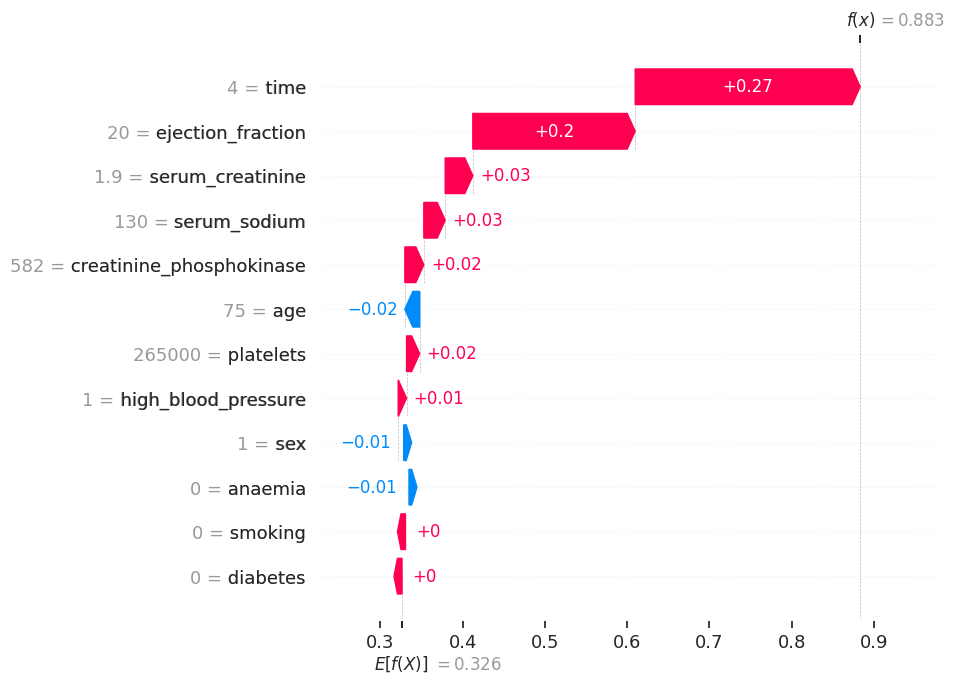

In [21]:
explainer = shap.TreeExplainer(rf)
shap_values_all = explainer.shap_values(X)
shap_values_all = np.array(shap_values_all)
shap_values_all = np.swapaxes(shap_values_all, 1, 2)

valid_svs = [shap_values_all[:, i, :] for i in range(shap_values_all.shape[1])]
per_class_means = [np.abs(sv).mean(axis=0) for sv in valid_svs]
global_mean_abs = np.mean(per_class_means, axis=0)

shap_imp_df = pd.DataFrame({
    'Feature': final_feature_names,
    'MeanAbsSHAP': global_mean_abs
}).sort_values('MeanAbsSHAP', ascending=False).reset_index(drop=True)


per_class_means = [np.abs(sv).mean(axis=0) for sv in valid_svs]
global_mean_abs = np.mean(per_class_means, axis=0)

shap_imp_df = pd.DataFrame({
    'Feature': final_feature_names,
    'MeanAbsSHAP': global_mean_abs
}).sort_values('MeanAbsSHAP', ascending=False).reset_index(drop=True)

display(shap_imp_df)

sample_idx = 0
class_to_show = 0
sv_for_class = valid_svs[class_to_show]

expected_val_class = explainer.expected_value
if isinstance(expected_val_class, (list, np.ndarray)):
    expected_val_class = expected_val_class[class_to_show]

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

shap.plots.waterfall(
    shap.Explanation(
        values=sv_for_class[sample_idx],
        base_values=expected_val_class,
        data=X.iloc[sample_idx].values,
        feature_names=list(X.columns)
    ),
    max_display=len(X.columns),
    show=True
)

#### Pooled Odds Ratio

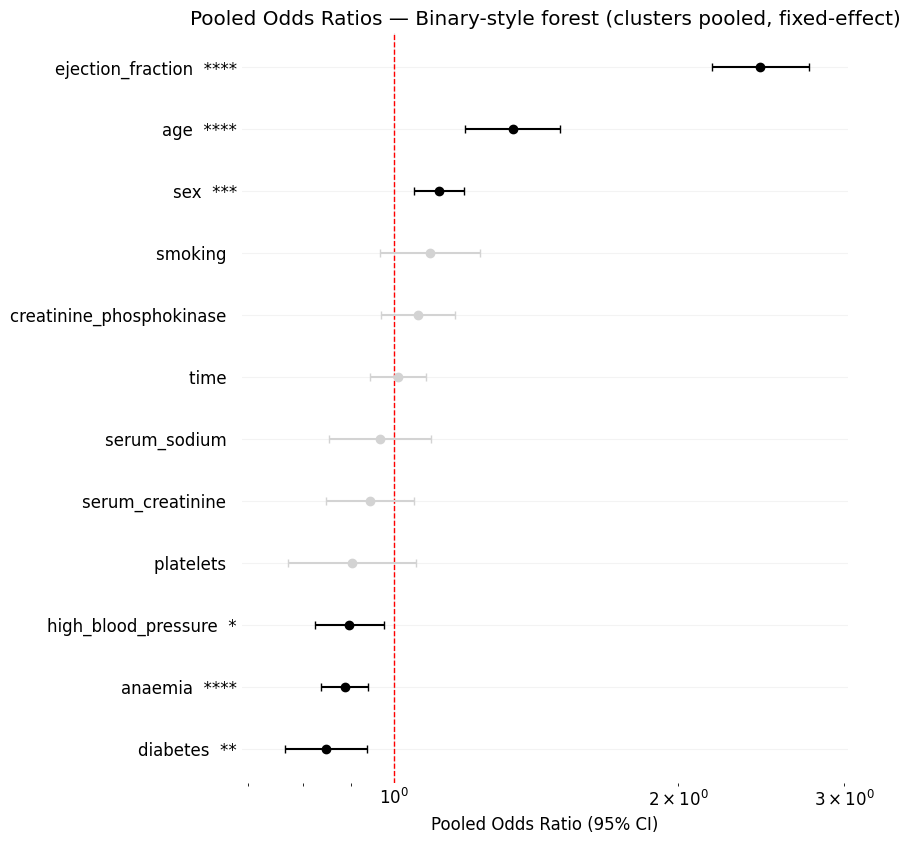

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Sırala: OR küçükten büyüğe (hocanınkine benzer sağa doğru kayma)
df = df_pooled.sort_values('pooled_OR', ascending=True).reset_index(drop=True)

# 2) Eksen verileri
y   = np.arange(len(df))
OR  = df["pooled_OR"].to_numpy()
LCL = df["pooled_LCL"].to_numpy()
UCL = df["pooled_UCL"].to_numpy()

fig, ax = plt.subplots(figsize=(9, 0.55*len(df)+2))

# 3) P<0.05 siyah, aksi gri
colors = np.where(df["p"].to_numpy() < 0.05, 'black', 'lightgray')

# 4) Nokta + %95 CI
for i, (x, lo, hi, c) in enumerate(zip(OR, LCL, UCL, colors)):
    ax.errorbar(x, i, xerr=[[x-lo], [hi-x]], fmt='o', capsize=3, ecolor=c, color=c, zorder=3)

# 5) Referans çizgi (OR=1)
ax.axvline(1.0, ls='--', color='red', lw=1, zorder=2)

# 6) Log-ekseni ve sınırlar
ax.set_xscale('log')
xmin = max(1e-2, float(np.nanmin(LCL))*0.9)
xmax = min(1e3,  float(np.nanmax(UCL))*1.1)
if not np.isfinite(xmin) or not np.isfinite(xmax) or xmin >= xmax:
    xmin, xmax = 0.5, 2.0
ax.set_xlim(xmin, xmax)

# 7) Y etiketleri (yıldızlarla)
def pstars(p):
    return '****' if p<1e-4 else ('***' if p<1e-3 else ('**' if p<1e-2 else ('*' if p<0.05 else '')))
ax.set_yticks(y, [f"{feat}  {pstars(p)}" for feat, p in zip(df["feature"], df["p"])])

ax.set_xlabel("Pooled Odds Ratio (95% CI)")
ax.set_title("Pooled Odds Ratios — Binary-style forest (clusters pooled, fixed-effect)")
ax.grid(True, axis='y', alpha=0.15)

# 8) >>> Dış çerçeveyi kaldır (çizimden SONRA, aynı ax üzerinde) <<<
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', length=0)

plt.tight_layout()
plt.show()


### 4. Cluster Interpretation

The analysis revealed five distinct patient clusters with meaningful clinical characteristics:
- <b> Cluster 0 </b> (n=97) represents a baseline profile, with feature averages close to the overall mean and a moderate mortality rate (~48.5%);
- <b> Cluster 1 </b> (n=109) is characterized by younger patients with longer survival times and higher prevalence of diabetes, corresponding to a lower observed mortality (~11.9%).;
- <b> Cluster 2 </b> (n=10) consists of patients with more severe physiological markers, particularly impaired kidney function, and shows a high mortality (~80%), suggesting a high-risk group.;
- <b> Cluster 3 </b> (n=77) includes older patients with higher ejection fraction, reflecting relatively preserved cardiac function, and exhibits a substantial mortality (~32.5%);
- <b> Cluster 4 </b> (n=6) represents rare or specialized patient types with heterogeneous characteristics, showing intermediate mortality (~50%).

The Random Forest classifier trained to predict cluster membership demonstrates excellent performance (accuracy = 0.922), confirming that the clusters are well-separated. Feature importance and SHAP analyses indicate that the primary drivers of cluster differentiation are survival time, ejection fraction, and age, consistent with clinical expectations. Overall, the clusters effectively capture patient subgroups that differ primarily by disease severity and survival trajectory, providing interpretable and clinically relevant patient stratification.